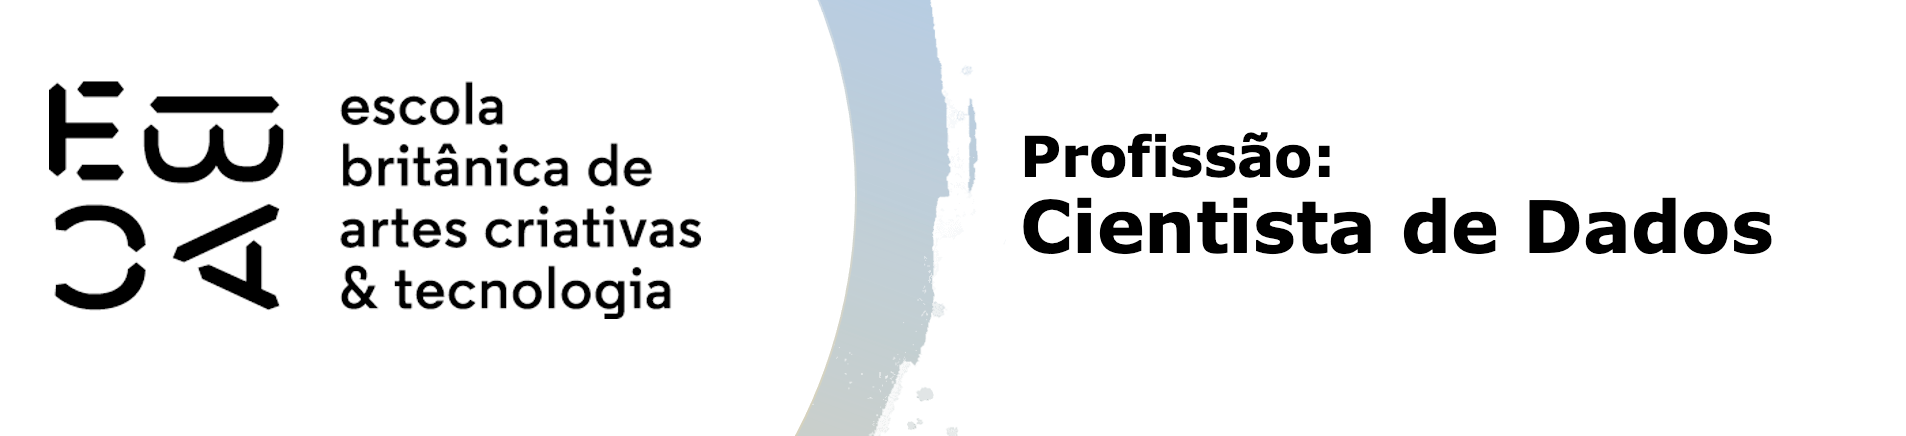

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [4]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE


import warnings
warnings.filterwarnings("ignore")


df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [6]:
#Último mês
df.data_ref.max()

Timestamp('2016-03-01 00:00:00')

In [7]:
# Retornando os ultimos 3 meses
meses = 3

data = pd.Series(pd.date_range('1/1/2016', periods = meses, freq = 'MS'))
date = pd.DataFrame(data)
date = date.rename({0:'oot'}, axis = 'columns')
date

,oot
0,2016-01-01
1,2016-02-01
2,2016-03-01


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [9]:
print('O dataset contém {} linhas e {} colunas.'.format(df.shape[0], df.shape[1]))

O dataset contém 750000 linhas e 15 colunas.


In [10]:
#Avaliação do tipo de variável
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [11]:
df['sexo'].describe()

count     750000
unique         2
top            F
freq      504580
Name: sexo, dtype: object

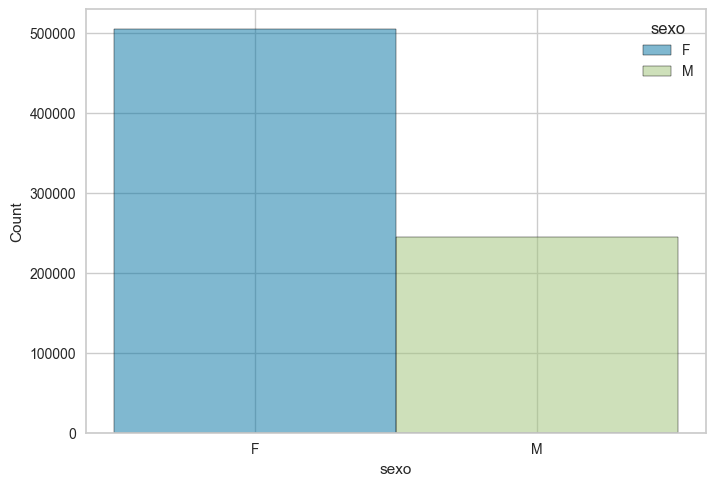

In [12]:
sns.histplot(data = df, x = df['sexo'], hue = 'sexo');

In [13]:
df['posse_de_veiculo'].describe()

count     750000
unique         2
top            N
freq      457954
Name: posse_de_veiculo, dtype: object

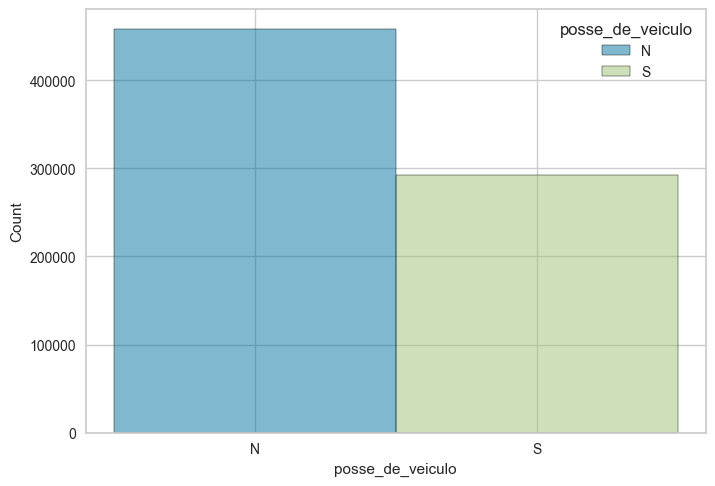

In [14]:
sns.histplot(data = df, x = df['posse_de_veiculo'], hue = 'posse_de_veiculo');

In [15]:
df['posse_de_imovel'].describe()

count     750000
unique         2
top            S
freq      503692
Name: posse_de_imovel, dtype: object

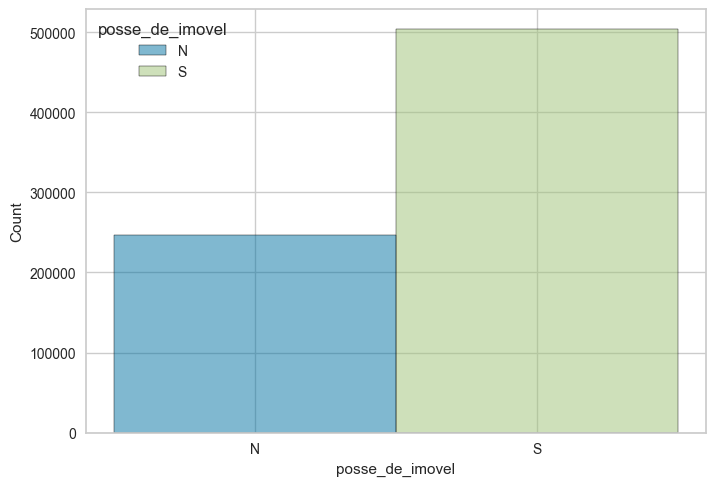

In [16]:
sns.histplot(data = df, x = df['posse_de_imovel'], hue = 'posse_de_imovel');

In [17]:
df['qtd_filhos'].describe()

count    750000.000000
mean          0.433251
std           0.739379
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          14.000000
Name: qtd_filhos, dtype: float64

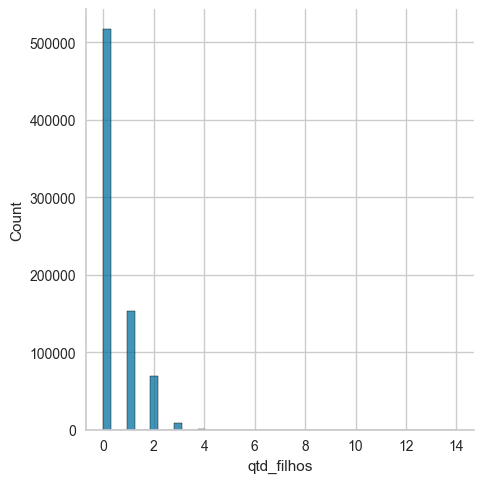

In [18]:
sns.displot(data = df, x = df['qtd_filhos'], bins = 45);

In [19]:
df['tipo_renda'].describe()

count          750000
unique              5
top       Assalariado
freq           385740
Name: tipo_renda, dtype: object

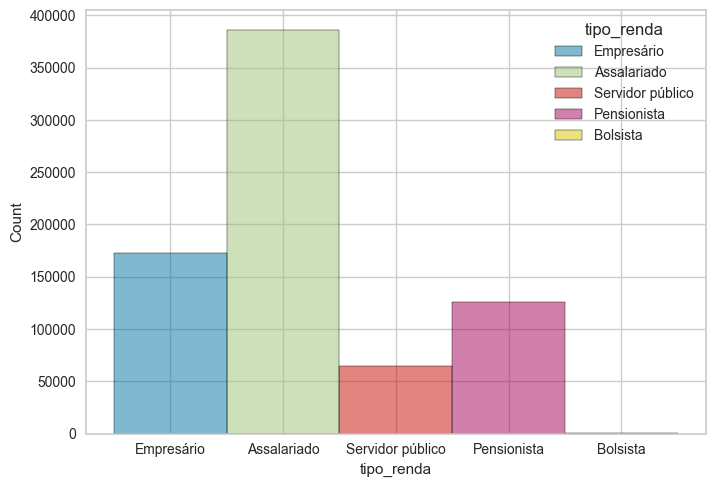

In [20]:
sns.histplot(data = df, x = df['tipo_renda'], hue = 'tipo_renda');

In [21]:
df['educacao'].describe()

count     750000
unique         5
top        Médio
freq      506836
Name: educacao, dtype: object

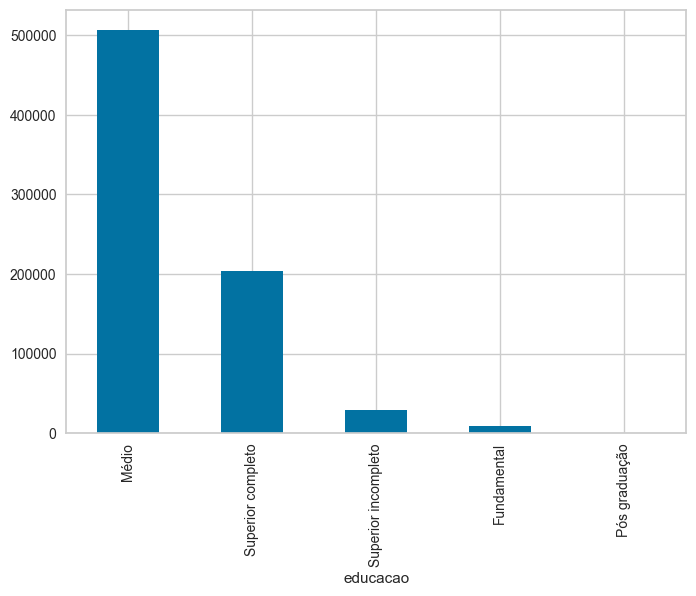

In [22]:
grafico_barras = df['educacao'].value_counts().plot.bar();

In [23]:
df['estado_civil'].describe()

count     750000
unique         5
top       Casado
freq      526472
Name: estado_civil, dtype: object

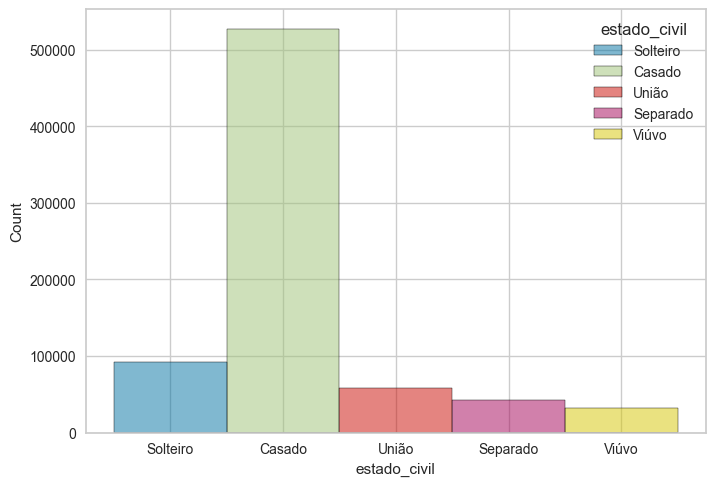

In [24]:
sns.histplot(data = df, x = df['estado_civil'], hue = 'estado_civil');

In [25]:
df['tipo_residencia'].describe()

count     750000
unique         6
top         Casa
freq      674294
Name: tipo_residencia, dtype: object

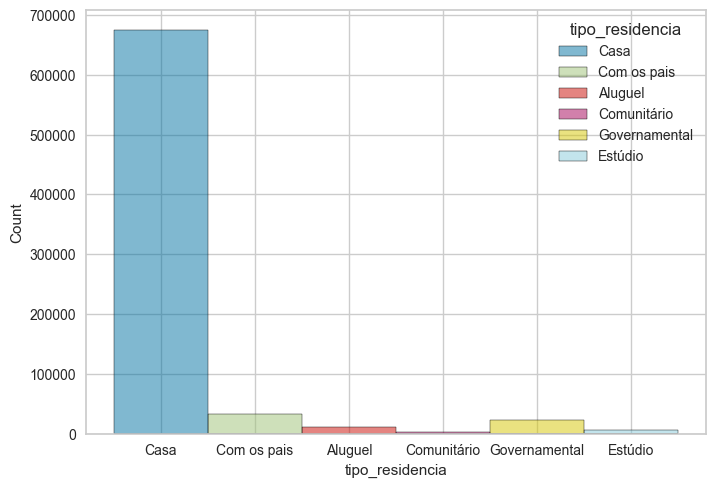

In [26]:
sns.histplot(data = df, x = df['tipo_residencia'], hue = 'tipo_residencia');

In [27]:
df['idade'].describe()

count    750000.000000
mean         43.804733
std          11.229868
min          22.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          68.000000
Name: idade, dtype: float64

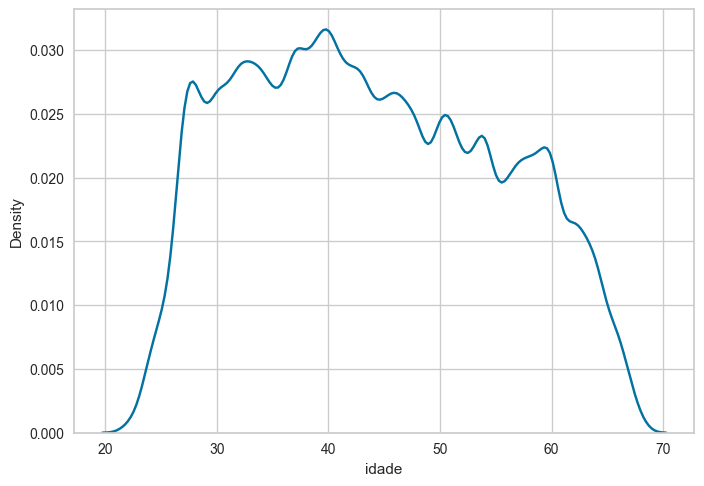

In [28]:
sns.kdeplot(data=df, x="idade");

In [29]:
df['tempo_emprego'].describe()

count    624043.000000
mean          7.748574
std           6.687455
min           0.117808
25%           3.049315
50%           6.046575
75%          10.183562
max          42.906849
Name: tempo_emprego, dtype: float64

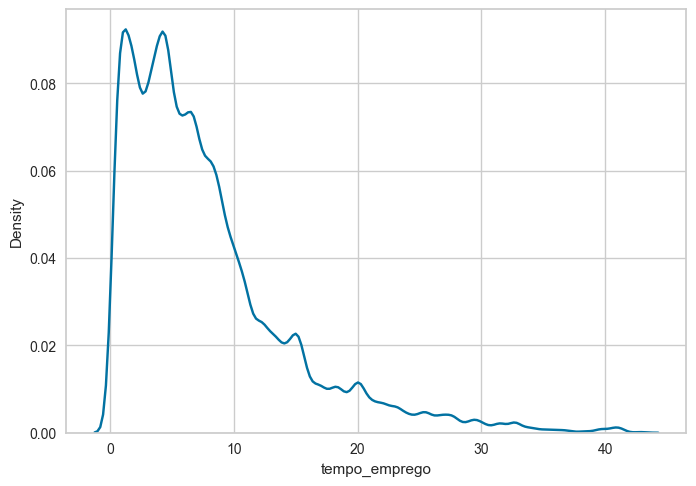

In [30]:
sns.kdeplot(data=df, x="tempo_emprego");

In [31]:
df['qt_pessoas_residencia'].describe()

count    750000.000000
mean          2.212241
std           0.903428
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          15.000000
Name: qt_pessoas_residencia, dtype: float64

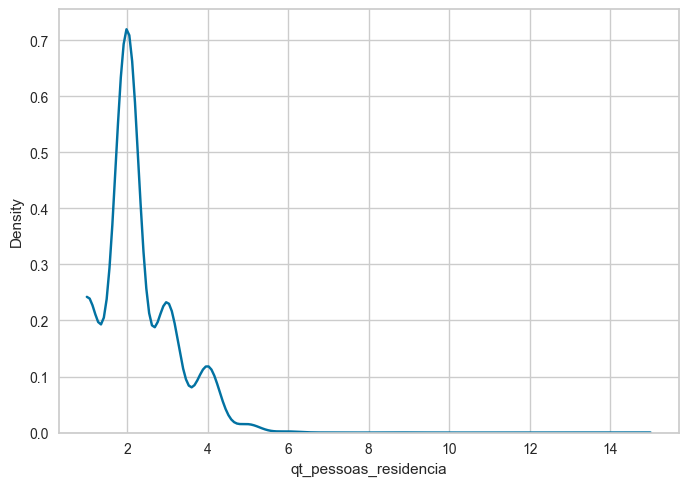

In [32]:
sns.kdeplot(data=df, x="qt_pessoas_residencia", bw_adjust=5, cut=0);

In [33]:
df['renda'].describe()

count    7.500000e+05
mean     2.323854e+04
std      7.910601e+04
min      1.076700e+02
25%      3.467700e+03
50%      7.861820e+03
75%      1.831828e+04
max      4.083986e+06
Name: renda, dtype: float64

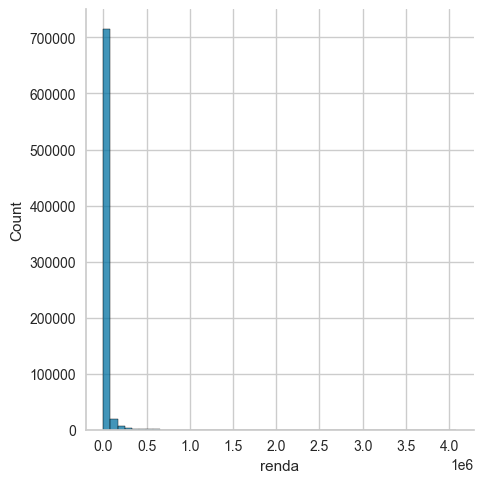

In [34]:
sns.displot(data = df, x = df['renda'], bins = 50);

In [35]:
df['mau'].describe()

count     750000
unique         2
top        False
freq      691357
Name: mau, dtype: object

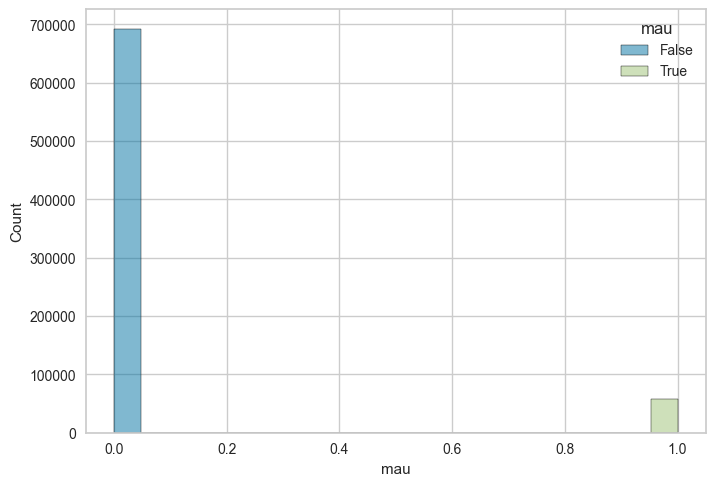

In [36]:
sns.histplot(data = df, x = df['mau'], hue = 'mau');

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

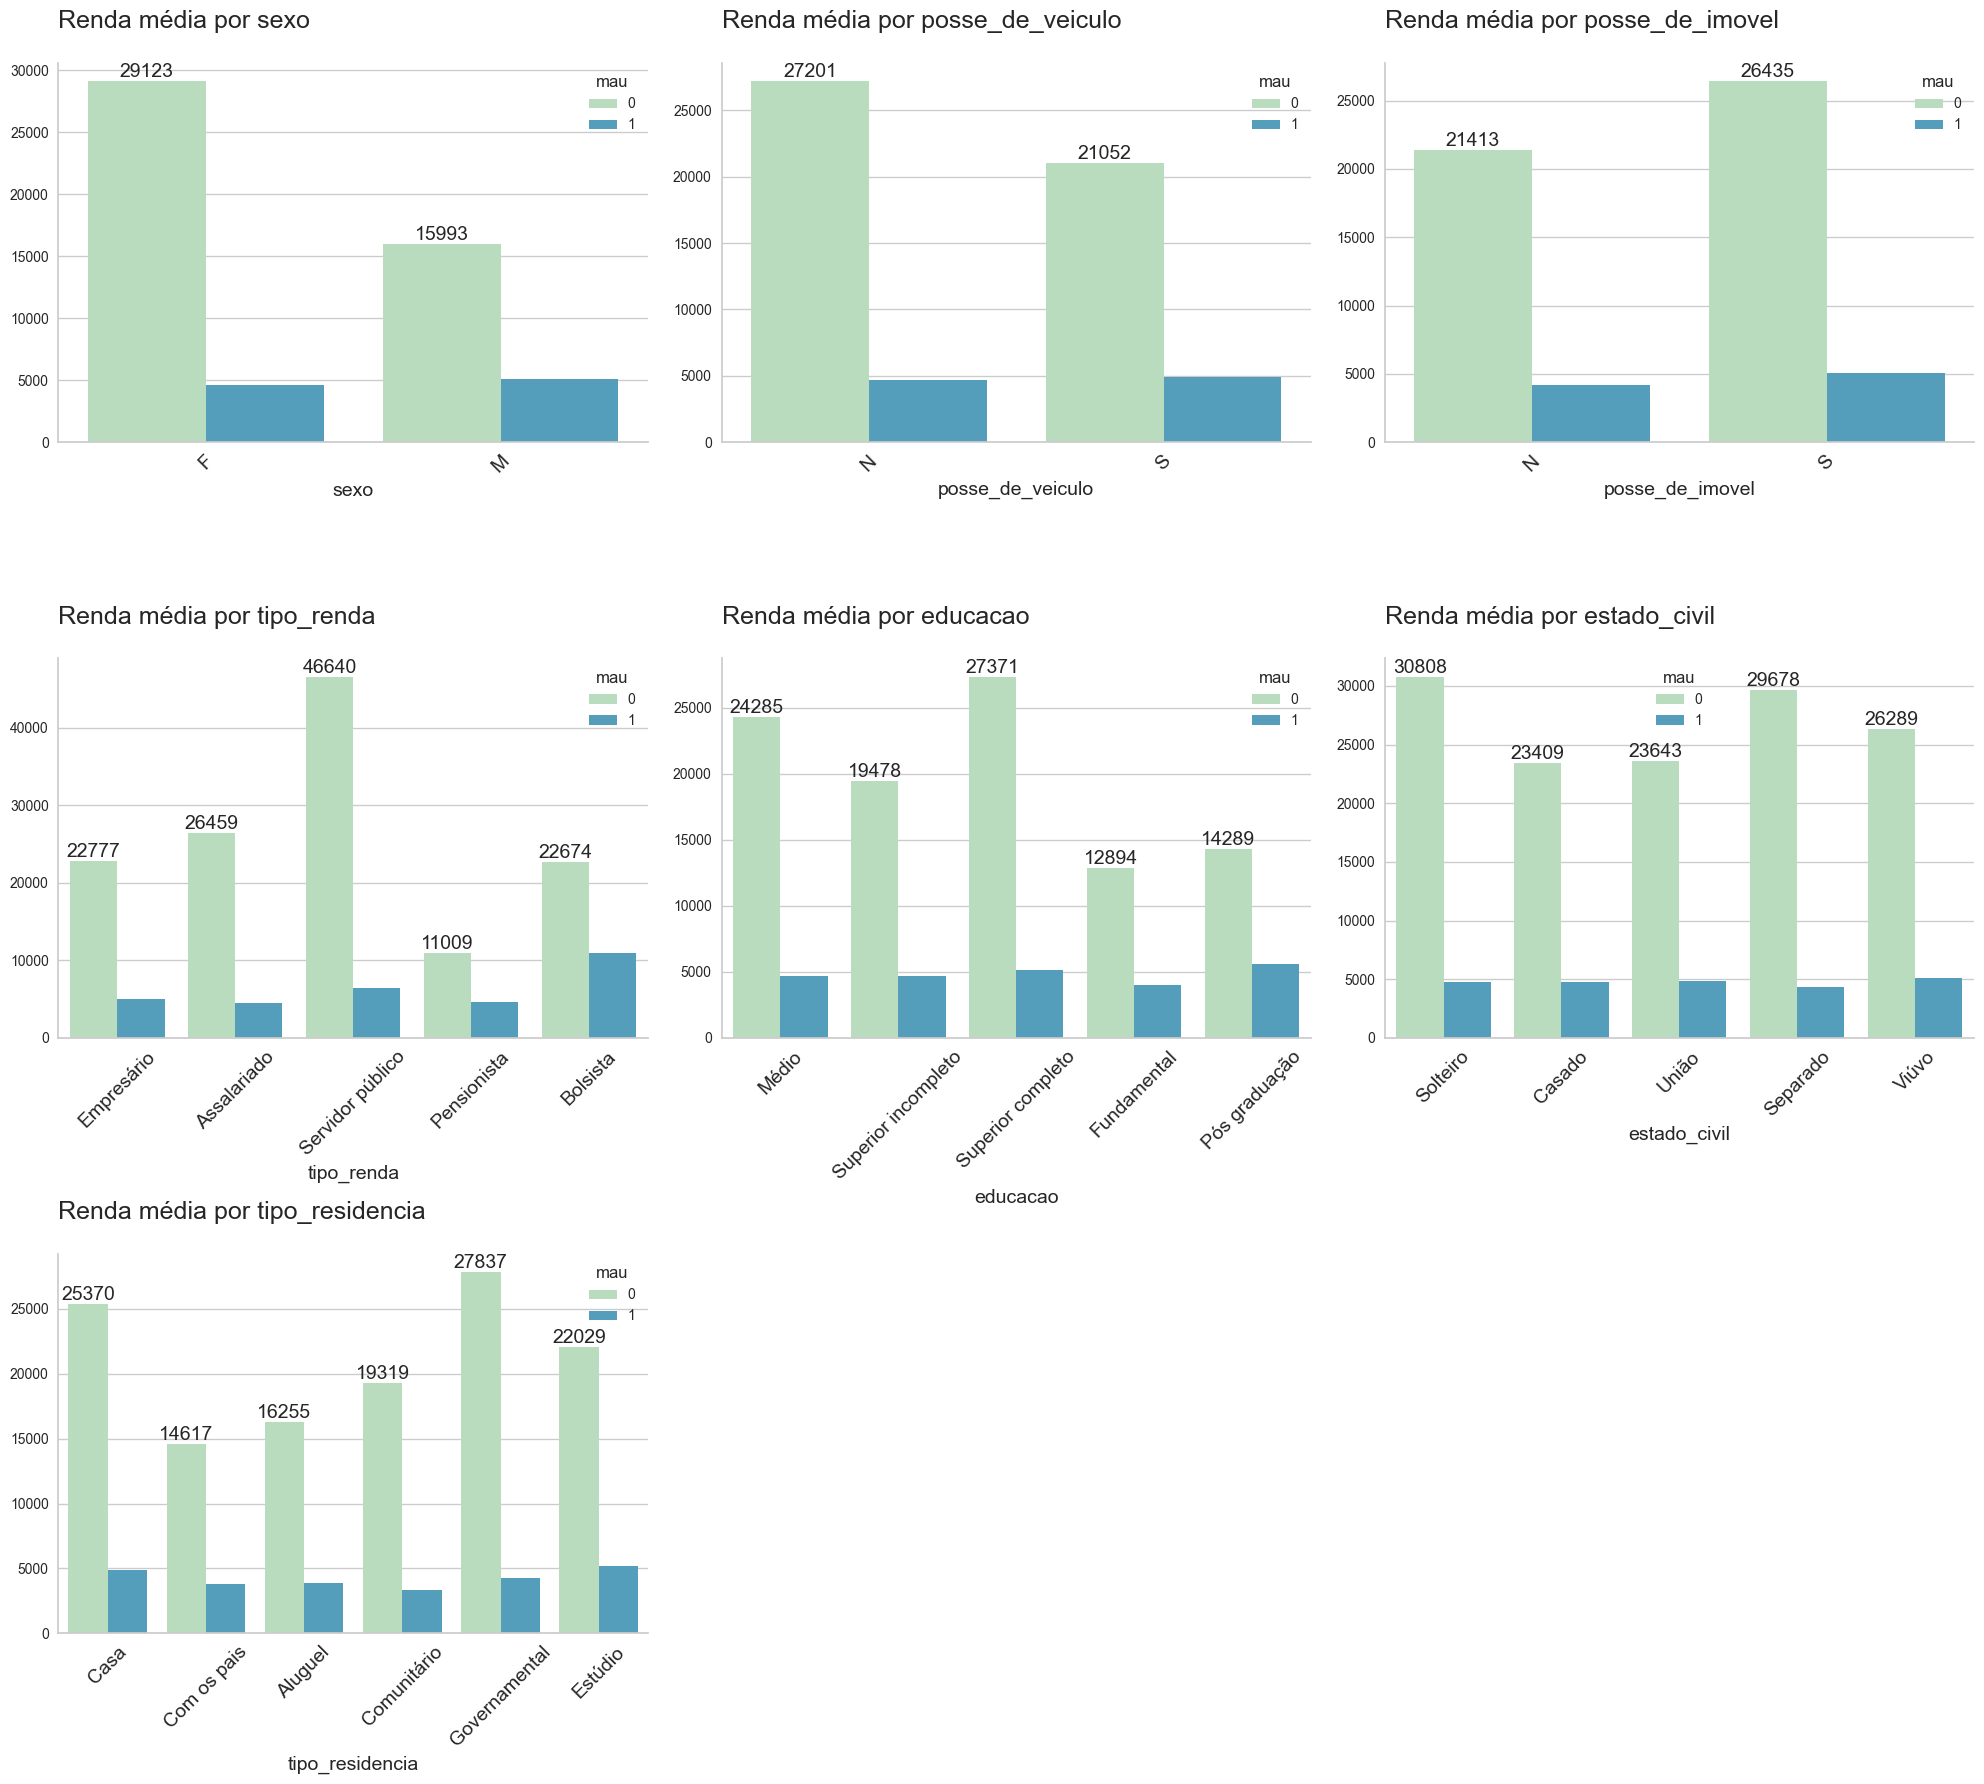

In [38]:
df['mau'] = df['mau'].astype('int')
cat_columns = list(df.select_dtypes(include=["object"]).columns)

# Plotting categoric features
plt.figure(figsize=(20, 18))

for i, col in enumerate(cat_columns):
    ax = plt.subplot(3, 3, i+1)
    ax = sns.barplot(data=df, x=col, y=df['renda'], hue=df['mau'], palette='GnBu', errorbar=None)
    ax.bar_label(ax.containers[0], fmt='%d', fontsize=14)
    # ax.bar_label(ax.containers[1], fmt='%d', fontsize=14)
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('')
    plt.xticks(size=14,rotation=45)
    plt.title(f'Renda média por {col}\n', loc='left', fontsize=18)
    sns.despine()
plt.tight_layout()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [40]:
data = df.sample(frac=0.95, random_state=42)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 15)
Conjunto de dados não usados no treino/teste, apenas como validação: (37500, 15)


In [41]:
data.index

RangeIndex(start=0, stop=712500, step=1)

In [42]:
pi_1 = setup(data = data, target = 'mau', session_id=42, experiment_name='credit_1',
                  normalize=True, normalize_method='zscore', 
                  transformation=True, transformation_method = 'quantile',
                  fix_imbalance=True, remove_multicollinearity = True, multicollinearity_threshold = 0.95)

,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 15)"
4,Transformed data shape,"(1133163, 34)"
5,Transformed train set shape,"(919412, 34)"
6,Transformed test set shape,"(213751, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [43]:
lr_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8904,0.7647,0.2661,0.2854,0.2755,0.2162,0.2164
1,0.8926,0.7735,0.2779,0.2993,0.2882,0.2302,0.2304
2,0.8895,0.7705,0.2728,0.2850,0.2788,0.2190,0.2190
3,0.8910,0.7733,0.2797,0.2940,0.2867,0.2277,0.2278
4,0.8910,0.7668,0.2679,0.2888,0.2780,0.2191,0.2193
5,0.8912,0.7662,0.2828,0.2961,0.2893,0.2305,0.2305
6,0.8929,0.7714,0.2722,0.2983,0.2847,0.2269,0.2272
7,0.8918,0.7696,0.2612,0.2887,0.2743,0.2159,0.2163
8,0.8923,0.7723,0.2781,0.2984,0.2879,0.2297,0.2299


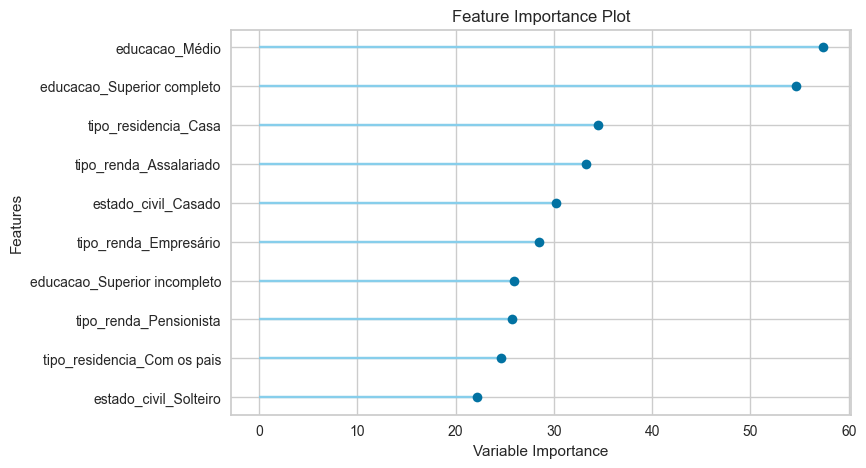

In [44]:
plot_model(lr_model, plot='feature')

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [46]:
## Accuracy
predict_pct = predict_model(lr_model, data=data)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8893,0.7700,0.2818,0.2880,0.2849,0.2249,0.2249


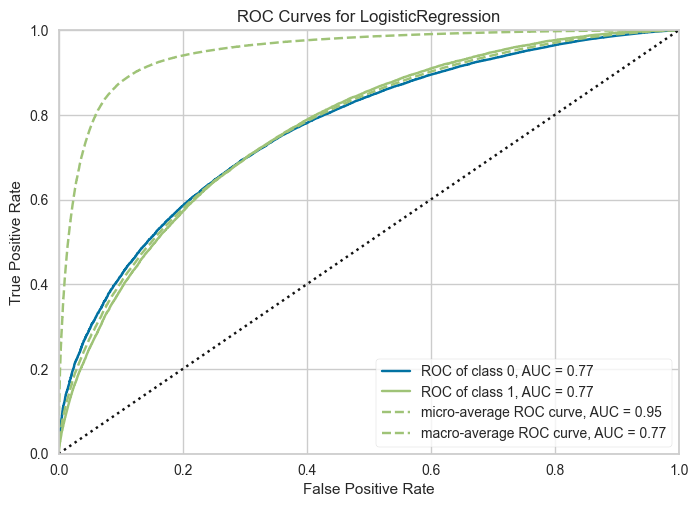

In [47]:
plot_model(lr_model, plot = 'auc')

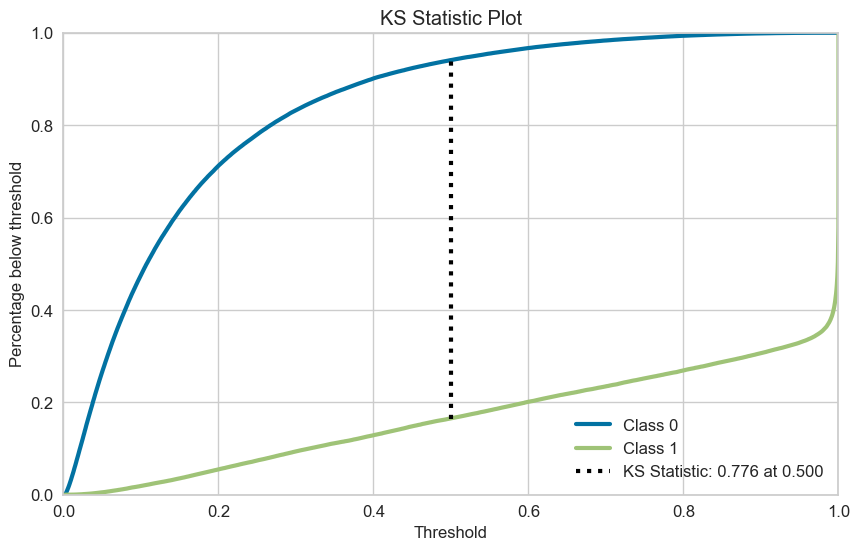

In [48]:
plot_model(lr_model, plot = 'ks')

In [49]:
unseen_predictions = predict_model(lr_model, data=data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8890,0.7685,0.2783,0.2761,0.2772,0.2171,0.2171


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [53]:
# Excluindo colunas que não devem ser usadas
df = df.drop(columns=['data_ref', 'index'], axis=1)

In [54]:
df

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,0
749996,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,0
749997,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,1
749998,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,1


In [55]:
from sklearn.impute import SimpleImputer

In [56]:
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

Observação: Imputador univariado para completar valores ausentes com estratégias simples. <br>
Substitua os valores ausentes usando uma estatística descritiva (por exemplo, média, mediana ou mais frequente) ao longo de cada coluna ou usando um valor constante.

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [59]:
def remove_outliers_by_quartile(df, low_quantile=0.1, high_quantile=0.85):
    # Copy DataFrame to avoid modifying the original
    df_cleaned = df.copy()

    # Filtering num columns
    num_columns = list(df.select_dtypes(include=["int", "float"]).columns)
    
    # Iterate over columns
    for col in num_columns:
        # Calculate lower and upper bounds using quartiles
        low_bound = df[col].quantile(low_quantile)
        high_bound = df[col].quantile(high_quantile)
        
        # Filter values based on bounds
        outliers = (df[col] < low_bound) | (df[col] > high_bound)
        
        # Replace outliers with NaN
        df_cleaned[col][outliers] = np.nan
    
    return df_cleaned
# Exemplo de uso
# df_cleaned = remove_outliers_by_quartile(data)

>> Remoção dos outliers >> troca por Nan values >> uso do SimpleImputer!

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

>> Opções: Feature impartance para usar somente as variáveis mais importante ou Recursive feature elimination para selecionar as melhores variáveis.

In [63]:
logistic_pipe = LogisticRegression(max_iter=200)
rfe = RFE(estimator=logistic_pipe, n_features_to_select=10, step=1)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [65]:
pca_pipe = PCA(n_components=5)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [67]:
X = dummy = pd.get_dummies(df, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'], dtype=int)

In [68]:
X

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,43,6.873973,1.0,2515.39,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,0,35,4.526027,2.0,3180.19,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2,31,0.243836,4.0,1582.29,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,54,12.772603,2.0,13721.17,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,31,8.432877,1.0,2891.08,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,0,48,3.038356,2.0,2109.99,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
749996,0,65,NaN,1.0,1389.39,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
749997,2,43,10.375342,4.0,649.06,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
749998,0,56,13.780822,1.0,4216.72,1,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [69]:
y = df['mau']

In [70]:
y

0         0
1         0
2         0
3         0
4         0
         ..
749995    0
749996    0
749997    1
749998    1
749999    0
Name: mau, Length: 750000, dtype: int32

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [72]:
pipe = Pipeline(steps=[("outliers", remove_outliers_by_quartile),
                       ('replace nans', simple_imputer),
                       ("pca", pca_pipe), 
                       ("get dummies", pd.get_dummies(data, prefix_sep="_"))])

#### Treinar um modelo de regressão logística com o resultado

In [74]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5):
        self.threshold = threshold
        self.lower_bound = None
        self.upper_bound = None
    
    def fit(self, X, y=None):
        self.lower_bound = np.percentile(X, 25) - self.threshold * (np.percentile(X, 75) - np.percentile(X, 25))
        self.upper_bound = np.percentile(X, 75) + self.threshold * (np.percentile(X, 75) - np.percentile(X, 25))
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed[(X < self.lower_bound) | (X > self.upper_bound)] = np.nan
        return X_transformed

In [76]:
logistic_pipe = LogisticRegression(max_iter=200)

pipe = Pipeline(steps=[("outliers", OutlierTransformer()),
                       ('replace nans', simple_imputer),
                       ("pca", pca_pipe),
                       ('Logistic', logistic_pipe)])

In [77]:
lr_pipe = pipe.fit(X_train, y_train)

In [78]:
lr_pipe.named_steps

{'outliers': OutlierTransformer(threshold=1.5),
 'replace nans': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               keep_empty_features=False, missing_values=nan, strategy='mean'),
 'pca': PCA(copy=True, iterated_power='auto', n_components=5, n_oversamples=10,
     power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
     tol=0.0, whiten=False),
 'Logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=200,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [79]:
lr_pred = pipe.predict(X_test)
lr_pred

array([0, 0, 0, ..., 0, 0, 0])

#### Salvar o pickle file do modelo treinado

In [81]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(lr_pred, open(nome_arquivo, 'wb'))

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [83]:
df = pd.read_feather('credit_scoring.ftr')
df

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [84]:
df.shape

(750000, 15)

In [85]:
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [86]:
dataset = df.sample(80000)

In [87]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [88]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (76000, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (4000, 13)


In [89]:
from pycaret.classification import *

### Configurando o pycaret

In [91]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(76000, 13)"
4,Transformed data shape,"(76000, 30)"
5,Transformed train set shape,"(53200, 30)"
6,Transformed test set shape,"(22800, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.7%


In [92]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [93]:
#forçando a variável qnt de filhos como numérica
data.qtd_filhos = data.qtd_filhos.astype(float)

In [94]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(76000, 13)"
4,Transformed data shape,"(76000, 30)"
5,Transformed train set shape,"(53200, 30)"
6,Transformed test set shape,"(22800, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.7%


### Comparando os modelos

In [96]:
best_model = compare_models(fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9219,0.7772,0.0312,0.5808,0.0592,0.0516,0.1209,2.0290
lr,Logistic Regression,0.9212,0.7755,0.0000,0.0000,0.0000,0.0000,0.0000,3.9400
ridge,Ridge Classifier,0.9212,0.6421,0.0000,0.0000,0.0000,0.0000,0.0000,0.4660
lda,Linear Discriminant Analysis,0.9212,0.6421,0.0000,0.0000,0.0000,0.0000,0.0000,0.5880
dummy,Dummy Classifier,0.9212,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5390
gbc,Gradient Boosting Classifier,0.9211,0.7791,0.0267,0.4892,0.0505,0.0427,0.0994,5.0820
lightgbm,Light Gradient Boosting Machine,0.9210,0.0000,0.0308,0.4958,0.0577,0.0488,0.1074,1.1560
knn,K Neighbors Classifier,0.9130,0.0000,0.0815,0.3041,0.1284,0.0986,0.1228,2.5800
svm,SVM - Linear Kernel,0.9101,0.7817,0.1180,0.2895,0.1355,0.1092,0.1264,0.5510
rf,Random Forest Classifier,0.8952,0.0000,0.1035,0.1919,0.1343,0.0840,0.0885,4.5950


In [97]:
print(best_model)

AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)


### Criando um modelo

In [99]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### Light Gradient Boosting Machine

In [101]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9194,0.0000,0.0286,0.3529,0.0530,0.0416,0.0816
1,0.9203,0.0000,0.0263,0.4074,0.0493,0.0402,0.0871
2,0.9201,0.0000,0.0191,0.3636,0.0363,0.0286,0.0682
3,0.9224,0.0000,0.0334,0.6364,0.0635,0.0561,0.1334
4,0.9222,0.0000,0.0310,0.6190,0.0591,0.0520,0.1263
5,0.9214,0.0000,0.0358,0.5172,0.0670,0.0574,0.1205
6,0.9212,0.0000,0.0286,0.5217,0.0542,0.0464,0.1082
7,0.9214,0.0000,0.0214,0.5625,0.0413,0.0357,0.0985
8,0.9220,0.0000,0.0476,0.5714,0.0879,0.0767,0.1486


### Model tunning (Hyperparameter Tunning)

#### Light Gradient Boosting Machine

In [104]:
tuned_lgbm = tune_model(lgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9132,0.0000,0.0668,0.2828,0.1081,0.0804,0.1043
1,0.9109,0.0000,0.0573,0.2330,0.0920,0.0628,0.0805
2,0.9124,0.0000,0.0597,0.2577,0.0969,0.0693,0.0905
3,0.9141,0.0000,0.0692,0.3021,0.1126,0.0858,0.1124
4,0.9070,0.0000,0.0430,0.1607,0.0678,0.0358,0.0446
5,0.9132,0.0000,0.0811,0.3063,0.1283,0.0986,0.1233
6,0.9145,0.0000,0.0667,0.3077,0.1096,0.0838,0.1119
7,0.9109,0.0000,0.0714,0.2632,0.1124,0.0814,0.1011
8,0.9122,0.0000,0.0667,0.2718,0.1071,0.0784,0.1005


Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Analisando o resultado do modelo

#### AUC Plot

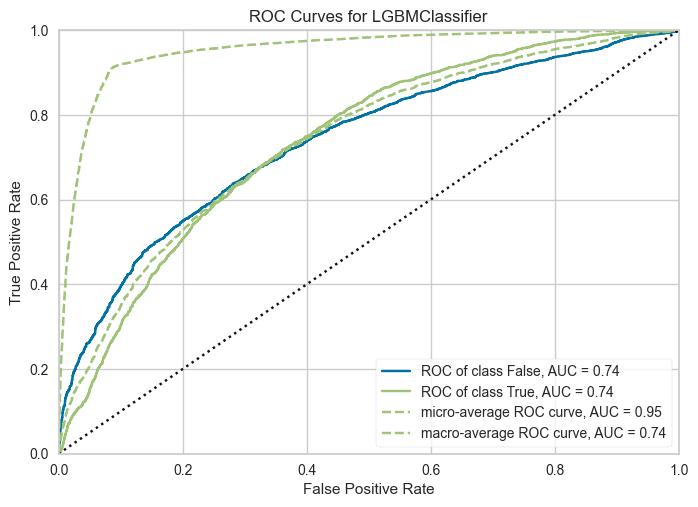

In [107]:
plot_model(tuned_lgbm, plot = 'auc')

#### Precision-Recall Plot

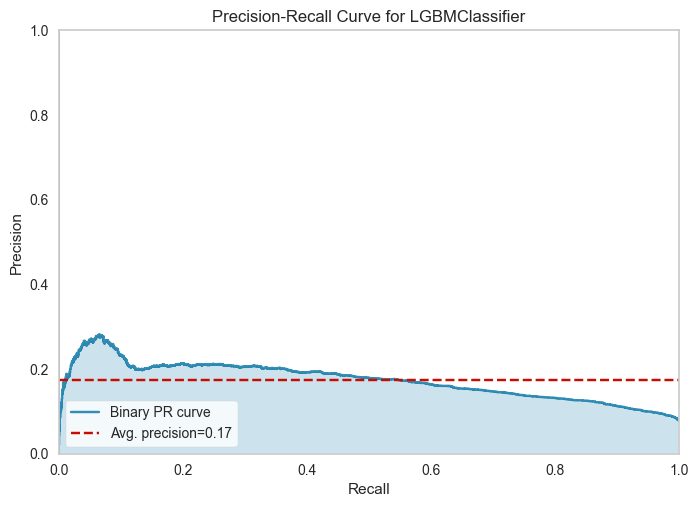

In [109]:
plot_model(tuned_lgbm, plot = 'pr')

#### Importância das variáveis (Feature Importance) Plot

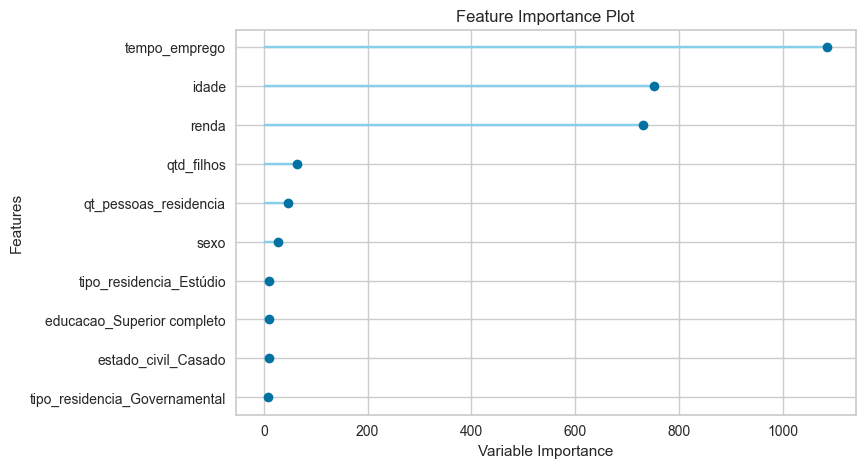

In [111]:
plot_model(tuned_lgbm, plot='feature')

#### Matriz de confusão (Confusion Matrix)

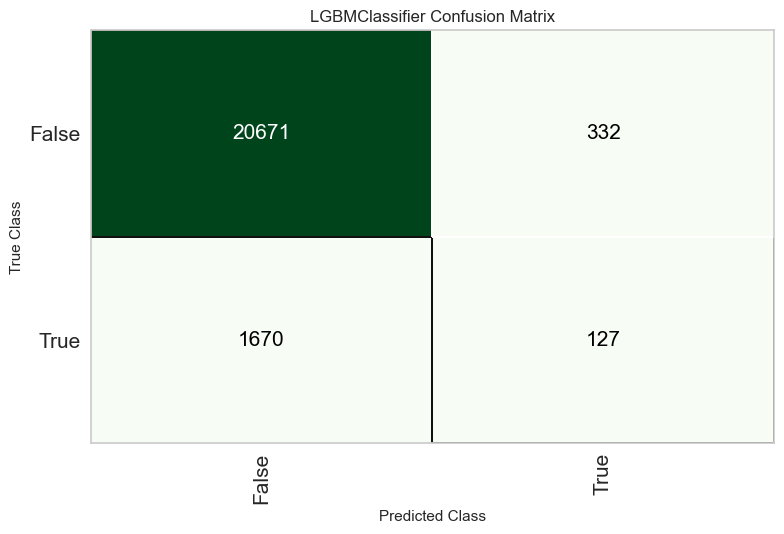

In [113]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')

In [114]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Predict na amostra de validação / hold-out

In [116]:
predict_model(tuned_lgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9122,0.7379,0.0707,0.2767,0.1126,0.0832,0.1053


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


### Finalizando o modelo para deploy

In [118]:
final_lgbm = finalize_model(tuned_lgbm)

In [119]:
print(final_lgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

In [120]:
predict_model(final_lgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9228,0.8505,0.0968,0.5577,0.1650,0.1451,0.2093


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


### Predizendo o conjunto de dados que não foi usado no treino

In [122]:
unseen_predictions = predict_model(final_lgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9180,0.7472,0.0461,0.2692,0.0787,0.0577,0.0837


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,N,0,Pensionista,Médio,Casado,Casa,53,NaN,2.0,1325.079956,True,0,0.8287
1,M,S,N,0,Assalariado,Superior incompleto,Casado,Comunitário,50,3.441096,2.0,4750.779785,False,0,0.9895
2,F,N,S,0,Empresário,Médio,Casado,Casa,46,2.534247,2.0,13950.919922,False,0,0.9860
3,F,N,S,0,Assalariado,Superior completo,Separado,Casa,49,1.824658,1.0,2739.770020,True,0,0.9169
4,F,S,S,2,Servidor público,Médio,Casado,Casa,39,16.695890,4.0,6103.270020,False,0,0.9923


In [123]:
unseen_predictions.dtypes

sexo                     category
posse_de_veiculo         category
posse_de_imovel          category
qtd_filhos                   int8
tipo_renda               category
educacao                 category
estado_civil             category
tipo_residencia          category
idade                        int8
tempo_emprego             float32
qt_pessoas_residencia     float32
renda                     float32
mau                          bool
prediction_label            int32
prediction_score          float64
dtype: object

In [124]:
from pycaret.utils.generic import check_metric
check_metric(unseen_predictions['mau'].astype(int), unseen_predictions['prediction_label'], metric = 'Accuracy')

0.918

### Salvando o modelo final

In [126]:
save_model(final_lgbm,'Final LGBM Model 14Set2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

### Carregando o modelo salvo

In [128]:
saved_final_lgbm = load_model('Final LGBM Model 14Set2024')

Transformation Pipeline and Model Successfully Loaded


In [129]:
saved_final_lgbm.steps

[('numerical_imputer',
  TransformerWrapper(exclude=None,
                     include=['qtd_filhos', 'idade', 'tempo_emprego',
                              'qt_pessoas_residencia', 'renda'],
                     transformer=SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               keep_empty_features=False,
                                               missing_values=nan,
                                               strategy='mean'))),
 ('categorical_imputer',
  TransformerWrapper(exclude=None,
                     include=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                              'tipo_renda', 'educacao', 'estado_civil',
                              'tipo_residencia'],
                     transformer=SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               keep_em